In [1]:
import pandas as pd
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import re
import sys 

In [2]:
# Set plot style for the notebook
sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

# --- CONFIGURATION ---

# 1. Map Traffic Intersections -> Air Quality Stations
# (Based on your "traffic_filter_summary" work)
TRAFFIC_TO_AQ_MAP = {
    'LAWRENCE AVE E / KENNEDY RD': 'Toronto East',
    'STEELES AVE W / DUFFERIN ST': 'Toronto North',
    'FRONT ST W / JOHN ST / PRIVATE ACCESS': 'Toronto Downtown',
    'ISLINGTON AVE / 401 C W ISLINGTON N RAMP / ALLENBY AVE': 'Toronto West'
}

# 2. Map Weather Stations -> Air Quality Stations
# (Based on your "meteorological_metadata.yml")
WEATHER_TO_AQ_MAP = {
    'Toronto_City_Centre_Downtown': 'Toronto Downtown',
    'Toronto_City_Ontario_East': 'Toronto East',
    'Toronto_Pearson_Intl_West': 'Toronto West',
    'Toronto_York_North': 'Toronto North'
}

# 3. Standardize Air Quality Station Names
# The raw CSV headers often have IDs like "Toronto East (33003)"
AQ_STATION_NAMES = {
    'Toronto East (33003)': 'Toronto East',
    'Toronto North (34021)': 'Toronto North',
    'Toronto Downtown (31129)': 'Toronto Downtown',
    'Toronto West (35125)': 'Toronto West'
}

print("Configuration loaded.")

Configuration loaded.


In [3]:

# --- 1. SETUP PATHS (Using the robust method we established) ---
def get_project_root():
    if '__file__' in globals(): return Path(__file__).resolve().parent.parent
    path = Path.cwd()
    while path.name:
        if (path / 'pyproject.toml').exists(): return path
        path = path.parent
    return Path.cwd()

PROJECT_ROOT = get_project_root()
AQ_DATA_DIR = PROJECT_ROOT / "data" / "air_quality" / "aq_data"

# Load Air Quality
def load_air_quality_final(folder_path=AQ_DATA_DIR):
    all_data = []
    search_pattern = os.path.join(folder_path, "*.csv")
    files = glob.glob(search_pattern)

    if not files:
        raise ValueError(f"No files found in {folder_path}")

    print(f"Processing {len(files)} files...")

    for file_path in files:
        # --- STEP A: Extract Metadata ---
        with open(file_path, 'r', encoding='latin1') as f:
            meta_lines = [next(f) for _ in range(10)]
            # Line 2=Name, Line 4=Lat, Line 5=Lon (Indices 1, 3, 4)
            station_name = meta_lines[1].split(',')[1].strip()
            lat = meta_lines[3].split(',')[1].strip()
            lon = meta_lines[4].split(',')[1].strip()

        # --- STEP B: Load Data (Your Logic) ---
        df = pd.read_csv(file_path, skiprows=10, index_col=False)
        
        # Renamed variable: 'Station_Name' -> 'Station' (Matches Traffic Data)
        df['Station'] = station_name
        df['Latitude'] = lat
        df['Longitude'] = lon
        
        all_data.append(df)

    # Combine everything
    df_aq = pd.concat(all_data, ignore_index=True)

    # Deal with any missing data
    df_aq.replace([9999, -999], pd.NA, inplace=True)

    #  Calculate Mean of Hourly Columns
    hourly_cols = [f'H{i:02d}' for i in range(1, 25)]
    df_aq['NO2_Mean'] = df_aq[hourly_cols].mean(axis=1)

    # Date conversion and cleaning
    df_aq['Date'] = pd.to_datetime(df_aq['Date'], errors='coerce')
    df_aq = df_aq.dropna(subset=['Date'])
    print(df_aq.shape)

    # Drop negatives
    # df_aq = df_aq[df_aq['NO2_Mean'] > 0]
    # print(df_aq.shape)
    
    # Optional: Sort for cleanliness
    df_aq = df_aq.sort_values(['Station', 'Date']).reset_index(drop=True)

    return df_aq

# --- EXECUTE ---
df_aq = load_air_quality_final()
print(f"✅ Master DataFrame Created: {len(df_aq)} rows")
df_aq.head()

Processing 4 files...
(4381, 31)
✅ Master DataFrame Created: 4381 rows


,Station ID,Pollutant,Date,H01,H02,H03,H04,H05,H06,H07,...,H19,H20,H21,H22,H23,H24,Station,Latitude,Longitude,NO2_Mean
0,31129,Nitrogen Dioxide,2022-01-01,17.1,18.1,8.7,6.9,9.6,11.7,11.0,...,9.0,9.2,8.8,8.1,8.5,9.3,Toronto Downtown (31129),43.645451,-79.3891,10.075
1,31129,Nitrogen Dioxide,2022-01-02,9.5,9.0,9.1,8.4,7.6,8.9,8.0,...,10.7,9.5,12.6,15.4,11.4,14.1,Toronto Downtown (31129),43.645451,-79.3891,10.208333
2,31129,Nitrogen Dioxide,2022-01-03,19.3,19.4,20.3,25.9,29.9,33.5,36.9,...,14.8,25.2,25.4,22.5,17.7,14.7,Toronto Downtown (31129),43.645451,-79.3891,19.5
3,31129,Nitrogen Dioxide,2022-01-04,17.2,13.1,14.2,13.2,15.8,17.8,21.6,...,15.8,15.7,13.2,13.2,11.2,12.2,Toronto Downtown (31129),43.645451,-79.3891,15.820833
4,31129,Nitrogen Dioxide,2022-01-05,9.0,7.8,7.0,6.9,6.0,6.1,8.8,...,10.6,9.9,10.3,10.8,10.4,8.4,Toronto Downtown (31129),43.645451,-79.3891,10.208333


Quality Control

=== Summary Statistics by Station (NO2 Mean) ===
                   count  unique    top  freq
Station                                      
Toronto Downtown  1081.0  1040.0  11.05   3.0
Toronto East      1094.0  1043.0  10.72   3.0
Toronto North     1092.0  1039.0   6.56   3.0
Toronto West      1093.0  1054.0   6.87   2.0


/var/folders/d7/l_md2zmj1wjglhzg6d75xsdh0000gn/T/ipykernel_16527/2610233483.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_aq, x='Station', y='NO2_Mean', palette="viridis")


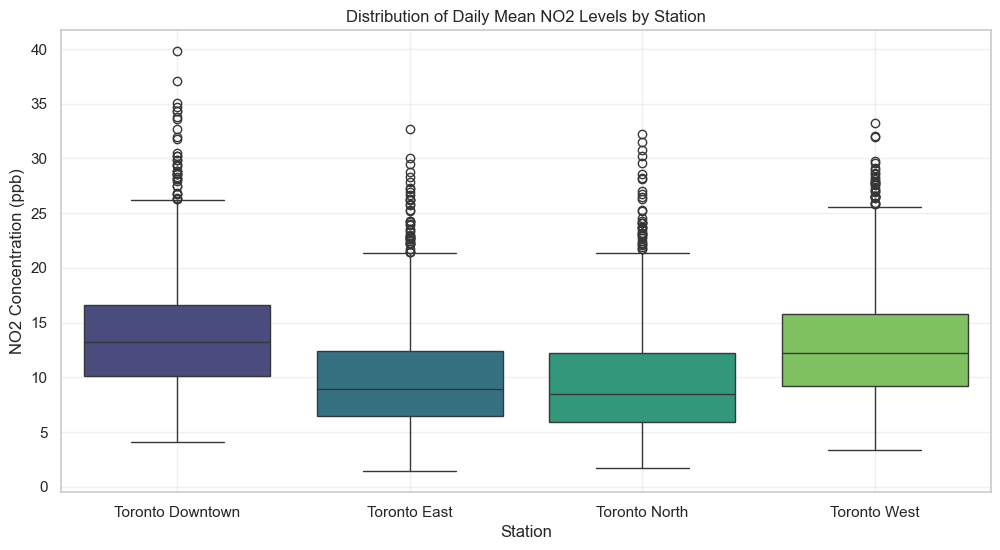

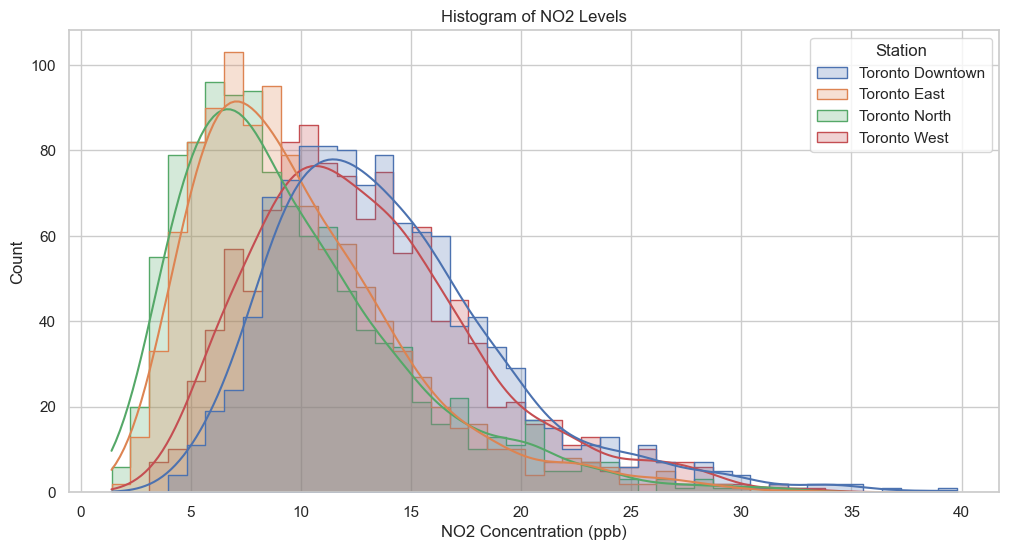

In [4]:

# 1. CLEAN STATION NAMES (Crucial for merging later)
# We map the raw "Name (ID)" format to the clean names your Traffic data expects
name_cleaner = {
    'Toronto Downtown (31129)': 'Toronto Downtown',
    'Toronto East (33003)': 'Toronto East',
    'Toronto North (34021)': 'Toronto North',
    'Toronto West (35125)': 'Toronto West'
}
# Apply mapping; if a name isn't in the dict, keep the original
df_aq['Station'] = df_aq['Station'].map(name_cleaner).fillna(df_aq['Station'])

# 2. GENERATE SUMMARY STATISTICS
print("=== Summary Statistics by Station (NO2 Mean) ===")
summary_stats = df_aq.groupby('Station')['NO2_Mean'].describe().round(2)
print(summary_stats)

# 3. VISUALIZE (Boxplots are best for comparing stations)
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_aq, x='Station', y='NO2_Mean', palette="viridis")
plt.title("Distribution of Daily Mean NO2 Levels by Station")
plt.ylabel("NO2 Concentration (ppb)")
plt.xlabel("Station")
plt.grid(True, alpha=0.3)
plt.show()

# 4. VISUALIZE (Histograms to check normality)
plt.figure(figsize=(12, 6))
sns.histplot(data=df_aq, x='NO2_Mean', hue='Station', kde=True, element="step")
plt.title("Histogram of NO2 Levels")
plt.xlabel("NO2 Concentration (ppb)")
plt.show()

In [ ]:
ss = df_aq[df_aq['Station'] == "Toronto West"]
ss

In [5]:
# 1. Count "NaN" values (Rows that exist but have no valid measurement)
print(f"Missing Measurements (NaNs): {df_aq['NO2_Mean'].isna().sum()}")

# 2. Count "Missing Days" (Days that are completely absent from the file)
full_range = pd.date_range(start=df_aq['Date'].min(), end=df_aq['Date'].max(), freq='D')

print("\nMissing Days per Station:")
for station, data in df_aq.groupby('Station'):
    missing_days = len(full_range) - len(data)
    print(f"  {station}: {missing_days}")

Missing Measurements (NaNs): 21

Missing Days per Station:
  Toronto Downtown: 0
  Toronto East: 0
  Toronto North: 3
  Toronto West: 0


# Simple Imputation

In [6]:
# 1. Ensure the data is sorted (crucial for rolling windows)
df_aq = df_aq.sort_values(['Station', 'Date'])

# 2. Fill NaNs using a 10-day centered rolling mean
df_aq['NO2_Mean'] = df_aq.groupby('Station')['NO2_Mean'].transform(
    lambda x: x.fillna(x.rolling(window=10, min_periods=1, center=True).mean())
)

# 3. Check if any NaNs remain 
# (This can happen if a gap is larger than your window)
remaining = df_aq['NO2_Mean'].isna().sum()
print(f"Remaining NaNs after rolling mean: {remaining}")



Remaining NaNs after rolling mean: 3


# Traffic Data

In [7]:
# Load traffic data

PROJECT_ROOT = get_project_root()
TRAFFIC_PATH = PROJECT_ROOT / "data" / "traffic" / "filtered_roads_with_sums.csv"
traffic_df = pd.read_csv(TRAFFIC_PATH)

# Transform traffic data to long format
date_col_pattern = re.compile(r"^x\d{4}_\d{2}_\d{2}$")
traffic_date_cols = [c for c in traffic_df.columns if date_col_pattern.match(str(c))]

traffic_long = []
for idx, row in traffic_df.iterrows():
    camera_road = row['camera_road']
    for col in traffic_date_cols:
        traffic_value = row[col]
        if pd.notna(traffic_value):
            date_str = col[1:]
            date = pd.to_datetime(date_str, format='%Y_%m_%d')
            traffic_long.append({
                'Date': date,
                'camera_road': camera_road,
                'traffic_count': traffic_value
            })

traffic_long_df = pd.DataFrame(traffic_long)
print(f"\nTraffic data loaded: {len(traffic_long_df)} records")
print(f"Date range: {traffic_long_df['Date'].min()} to {traffic_long_df['Date'].max()}")
print(f"\nLocations: {traffic_long_df['camera_road'].unique()}")

# Create location mapping
location_mapping = {
    'LAWRENCE AVE E / KENNEDY RD': 'Toronto East',
    'STEELES AVE W / DUFFERIN ST': 'Toronto North',
    'FRONT ST W / JOHN ST / PRIVATE ACCESS': 'Toronto Downtown',
    'ISLINGTON AVE / 401 C W ISLINGTON N RAMP / ALLENBY AVE': 'Toronto West'
}

# Add station names to traffic data
traffic_long_df['Station'] = traffic_long_df['camera_road'].map(location_mapping)

print("Location Mapping:")
for traffic_loc, aq_station in location_mapping.items():
    print(f"  {aq_station}: {traffic_loc}")


Traffic data loaded: 4300 records
Date range: 2022-02-03 00:00:00 to 2025-10-31 00:00:00

Locations: <StringArray>
[                 'FRONT ST W / JOHN ST / PRIVATE ACCESS',
                            'STEELES AVE W / DUFFERIN ST',
 'ISLINGTON AVE / 401 C W ISLINGTON N RAMP / ALLENBY AVE',
                            'LAWRENCE AVE E / KENNEDY RD']
Length: 4, dtype: str
Location Mapping:
  Toronto East: LAWRENCE AVE E / KENNEDY RD
  Toronto North: STEELES AVE W / DUFFERIN ST
  Toronto Downtown: FRONT ST W / JOHN ST / PRIVATE ACCESS
  Toronto West: ISLINGTON AVE / 401 C W ISLINGTON N RAMP / ALLENBY AVE


In [8]:
traffic_clean = traffic_long_df.copy()
traffic_clean.head()

,Date,camera_road,traffic_count,Station
0,2022-02-03,FRONT ST W / JOHN ST / PRIVATE ACCESS,320.0,Toronto Downtown
1,2022-02-04,FRONT ST W / JOHN ST / PRIVATE ACCESS,269.0,Toronto Downtown
2,2022-02-05,FRONT ST W / JOHN ST / PRIVATE ACCESS,161.0,Toronto Downtown
3,2022-02-06,FRONT ST W / JOHN ST / PRIVATE ACCESS,98.0,Toronto Downtown
4,2022-02-07,FRONT ST W / JOHN ST / PRIVATE ACCESS,151.0,Toronto Downtown


In [9]:
df_aq.head()

,Station ID,Pollutant,Date,H01,H02,H03,H04,H05,H06,H07,...,H19,H20,H21,H22,H23,H24,Station,Latitude,Longitude,NO2_Mean
0,31129,Nitrogen Dioxide,2022-01-01,17.1,18.1,8.7,6.9,9.6,11.7,11.0,...,9.0,9.2,8.8,8.1,8.5,9.3,Toronto Downtown,43.645451,-79.3891,10.075
1,31129,Nitrogen Dioxide,2022-01-02,9.5,9.0,9.1,8.4,7.6,8.9,8.0,...,10.7,9.5,12.6,15.4,11.4,14.1,Toronto Downtown,43.645451,-79.3891,10.208333
2,31129,Nitrogen Dioxide,2022-01-03,19.3,19.4,20.3,25.9,29.9,33.5,36.9,...,14.8,25.2,25.4,22.5,17.7,14.7,Toronto Downtown,43.645451,-79.3891,19.5
3,31129,Nitrogen Dioxide,2022-01-04,17.2,13.1,14.2,13.2,15.8,17.8,21.6,...,15.8,15.7,13.2,13.2,11.2,12.2,Toronto Downtown,43.645451,-79.3891,15.820833
4,31129,Nitrogen Dioxide,2022-01-05,9.0,7.8,7.0,6.9,6.0,6.1,8.8,...,10.6,9.9,10.3,10.8,10.4,8.4,Toronto Downtown,43.645451,-79.3891,10.208333


# Combinded Data


In [10]:
# Merge on both Date and Station to ensure the right traffic matches the right sensor
df_combined = pd.merge(
    df_aq, 
    traffic_clean, 
    on=['Date', 'Station'], 
    how='inner'
)
df_combined['traffic_count'] = pd.to_numeric(df_combined['traffic_count'], errors='coerce')
df_combined['NO2_Mean'] = pd.to_numeric(df_combined['NO2_Mean'], errors='coerce')

# Rename the traffic column if it's just a number right now
# Based on your head(), it looks like the 3rd column is the count
# df_combined.rename(columns={'320.0': 'Traffic_Count'}, inplace=True)

In [11]:
print(f"Original AQ rows: {len(df_aq)}")
print(f"Merged rows: {len(df_combined)}")
print(f"Stations in merged data: {df_combined['Station'].unique()}")

# View the first few rows of the final joined product
df_combined[['Date', 'Station', 'NO2_Mean', 'traffic_count']].head()

Original AQ rows: 4381
Merged rows: 3343
Stations in merged data: <StringArray>
['Toronto Downtown', 'Toronto East', 'Toronto North', 'Toronto West']
Length: 4, dtype: str


,Date,Station,NO2_Mean,traffic_count
0,2022-02-03,Toronto Downtown,14.404167,320.0
1,2022-02-04,Toronto Downtown,21.079167,269.0
2,2022-02-05,Toronto Downtown,15.370833,161.0
3,2022-02-06,Toronto Downtown,10.116667,98.0
4,2022-02-07,Toronto Downtown,16.562500,151.0


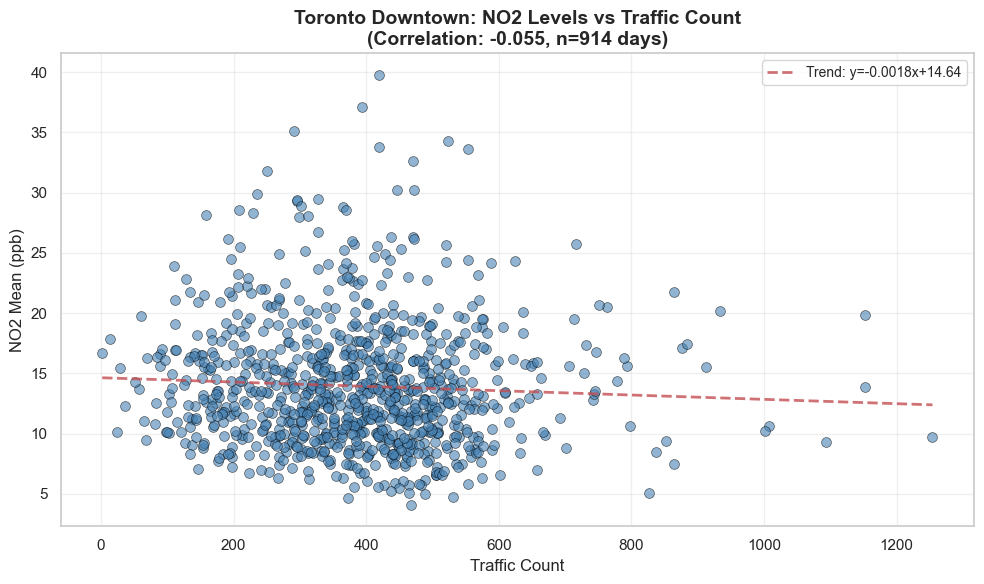

Correlation coefficient: -0.0554
Sample size: 914 days


In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Choose one station (you can change this to any station you want)
station_name = 'Toronto Downtown'

# Filter data for this station
station_data = df_combined[df_combined['Station'] == station_name].copy()
station_data = station_data.dropna(subset=['traffic_count', 'NO2_Mean'])

# Create the plot
plt.figure(figsize=(10, 6))

# Scatter plot
plt.scatter(station_data['traffic_count'], 
           station_data['NO2_Mean'], 
           alpha=0.6, 
           s=50,
           color='steelblue',
           edgecolors='black',
           linewidth=0.5)

# Add trend line
z = np.polyfit(station_data['traffic_count'], station_data['NO2_Mean'], 1)
p = np.poly1d(z)

x_line = np.linspace(station_data['traffic_count'].min(), 
                    station_data['traffic_count'].max(), 
                    100)
plt.plot(x_line, 
        p(x_line), 
        "r--", 
        alpha=0.8, 
        linewidth=2,
        label=f'Trend: y={z[0]:.4f}x+{z[1]:.2f}')

# Calculate correlation
corr = station_data['traffic_count'].corr(station_data['NO2_Mean'])

# Labels and title
plt.xlabel('Traffic Count', fontsize=12)
plt.ylabel('NO2 Mean (ppb)', fontsize=12)
plt.title(f'{station_name}: NO2 Levels vs Traffic Count\n(Correlation: {corr:.3f}, n={len(station_data)} days)', 
         fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()

print(f"Correlation coefficient: {corr:.4f}")
print(f"Sample size: {len(station_data)} days")

# Model Fitting

In [13]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

# Prepare data for one station
station_name = 'Toronto Downtown'
station_data = df_combined[df_combined['Station'] == station_name].copy()
station_data = station_data.dropna(subset=['traffic_count', 'NO2_Mean'])

X = station_data[['traffic_count']]
y = station_data['NO2_Mean']

# Fit the model
model = LinearRegression()
model.fit(X, y)

# Make predictions
y_pred = model.predict(X)

# Evaluate
r2 = r2_score(y, y_pred)
rmse = np.sqrt(mean_squared_error(y, y_pred))

print(f"=== Linear Regression Results for {station_name} ===")
print(f"Coefficient (slope): {model.coef_[0]:.6f}")
print(f"Intercept: {model.intercept_:.4f}")
print(f"R² Score: {r2:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"\nInterpretation: For every 1 vehicle increase in traffic,")
print(f"NO2 increases by {model.coef_[0]:.6f} ppb")

=== Linear Regression Results for Toronto Downtown ===
Coefficient (slope): -0.001795
Intercept: 14.6374
R² Score: 0.0031
RMSE: 5.1872

Interpretation: For every 1 vehicle increase in traffic,
NO2 increases by -0.001795 ppb


# Adding Weather


In [18]:
# --- CONFIGURATION ---
WEATHER_DATA_DIR = PROJECT_ROOT / "data" / "weather" / "weather_data"

# Added 'Spd of Max Gust (km/h)' back in
WEATHER_COLS_TO_KEEP = {
    'Date/Time': 'Date',
    'Mean Temp (°C)': 'Mean_Temp',
    'Min Temp (°C)': 'Min_Temp',
    'Max Temp (°C)': 'Max_Temp',
    'Total Precip (mm)': 'Total_Precip',
    'Spd of Max Gust (km/h)': 'Max_Gust_Spd'
}

def load_weather_data(folder_path=WEATHER_DATA_DIR):
    all_weather = []
    search_pattern = os.path.join(folder_path, "*.csv")
    files = glob.glob(search_pattern)
    
    print(f"Processing {len(files)} weather files...")

    # 1. Load all raw data
    for file_path in files:
        df = pd.read_csv(file_path)
        filename = Path(file_path).stem 
        
        if filename in WEATHER_TO_AQ_MAP:
            target_station_name = WEATHER_TO_AQ_MAP[filename]
        else:
            continue

        # Rename columns
        df = df.rename(columns=WEATHER_COLS_TO_KEEP)
        cols_to_select = [c for c in WEATHER_COLS_TO_KEEP.values() if c in df.columns]
        df = df[cols_to_select].copy()
        
        df['Station'] = target_station_name
        all_weather.append(df)

    df_weather = pd.concat(all_weather, ignore_index=True)
    df_weather['Date'] = pd.to_datetime(df_weather['Date'])
    
    # --- STEP 2: Handle Temperature & Precip (Station-Specific LOCF) ---
    # Sort for correct time-based filling
    df_weather = df_weather.sort_values(by=['Station', 'Date'])
    
    cols_local = ['Mean_Temp', 'Min_Temp', 'Max_Temp', 'Total_Precip']
    print("Imputing local vars (Temp, Precip) with LOCF...")
    for col in cols_local:
        if col in df_weather.columns:
            df_weather[col] = df_weather.groupby('Station')[col].ffill()

    # --- STEP 3: Handle Wind (Regional Proxy from Toronto West) ---
    print("Processing Regional Wind Data (Proxy: Toronto West)...")
    
    # A. Extract only Toronto West data (Pearson is usually the most reliable)
    # We assume 'Toronto West' is the name in your WEATHER_TO_AQ_MAP
    wind_proxy = df_weather[df_weather['Station'] == 'Toronto West'][['Date', 'Max_Gust_Spd']].copy()
    
    # B. Sort and LOCF the wind data specifically
    wind_proxy = wind_proxy.sort_values('Date')
    wind_proxy['Max_Gust_Spd'] = wind_proxy['Max_Gust_Spd'].ffill()
    
    # C. Drop the original (gappy) wind column from the main dataset
    if 'Max_Gust_Spd' in df_weather.columns:
        df_weather = df_weather.drop(columns=['Max_Gust_Spd'])
        
    # D. Merge the filled "Regional Wind" back to ALL stations based on Date
    # This effectively copies Toronto West wind to East, North, and Downtown
    df_weather = pd.merge(df_weather, wind_proxy, on='Date', how='left')
    
    # Fill remaining NaNs (if Toronto West started later than other stations) with 0 or mean
    df_weather['Max_Gust_Spd'] = df_weather['Max_Gust_Spd'].fillna(0)

    print(f"✅ Weather Data Loaded & Imputed: {len(df_weather)} rows")
    return df_weather

# --- EXECUTE ---
df_weather = load_weather_data()
df_weather.head()

Processing 4 weather files...
Imputing local vars (Temp, Precip) with LOCF...
Processing Regional Wind Data (Proxy: Toronto West)...
✅ Weather Data Loaded & Imputed: 5844 rows


,Date,Mean_Temp,Min_Temp,Max_Temp,Total_Precip,Station,Max_Gust_Spd
0,2022-01-01,1.8,-1.8,5.3,1.6,Toronto Downtown,46.0
1,2022-01-02,-6.1,-10.3,-1.8,0.2,Toronto Downtown,52.0
2,2022-01-03,-7.8,-12.3,-3.3,0.0,Toronto Downtown,52.0
3,2022-01-04,-0.8,-4.9,3.3,0.0,Toronto Downtown,33.0
4,2022-01-05,0.3,-4.2,4.8,0.0,Toronto Downtown,68.0


In [19]:
df_weather[df_weather['Station'] == "Toronto North"]

,Date,Mean_Temp,Min_Temp,Max_Temp,Total_Precip,Station,Max_Gust_Spd
2922,2022-01-01,2.5,1.0,4.0,3.0,Toronto North,46.0
2923,2022-01-02,-7.0,-8.0,-6.0,1.0,Toronto North,52.0
2924,2022-01-03,-10.3,-16.5,-4.0,0.0,Toronto North,52.0
2925,2022-01-04,-3.0,-10.0,4.0,0.0,Toronto North,33.0
2926,2022-01-05,0.0,-3.5,3.5,1.2,Toronto North,68.0
...,...,...,...,...,...,...,...
4378,2025-12-27,-5.8,-9.5,-2.0,0.0,Toronto North,58.0
4379,2025-12-28,0.0,-6.5,6.5,34.0,Toronto North,45.0
4380,2025-12-29,-0.3,-5.5,5.0,0.0,Toronto North,78.0
4381,2025-12-30,-5.8,-8.5,-3.0,0.0,Toronto North,68.0


In [20]:
# --- MERGE STEP ---

# Merge the Clean Weather data into the Combined (Traffic + AQ) data
# We use 'left' to ensure we don't lose any Traffic/AQ rows if weather is missing (unlikely now)
df_final = pd.merge(
    df_combined, 
    df_weather, 
    on=['Date', 'Station'], 
    how='left'
)

# --- SANITY CHECKS ---
print(f"Original shape: {df_combined.shape}")
print(f"New shape:      {df_final.shape}")
print("-" * 30)

# Check 1: Did the Wind Data propagate to a station that didn't have it originally?
# Let's check 'Toronto East' (which originally had no valid wind data)
test_station = 'Toronto East'
sample_rows = df_final[df_final['Station'] == test_station].head(3)

print(f"Sample Wind Data for {test_station} (Should be non-null):")
print(sample_rows[['Date', 'Station', 'Max_Gust_Spd']])

# Check 2: Quick Correlation Scan
# We expect Wind and Precip to negatively correlate with NO2 (cleaning the air)
# We expect Traffic to positively correlate with NO2
correlations = df_final[['NO2_Mean', 'traffic_count', 'Mean_Temp', 'Max_Gust_Spd', 'Total_Precip']].corr()['NO2_Mean']
print("-" * 30)
print("Correlations with NO2 (Air Quality):")
print(correlations)

Original shape: (3343, 33)
New shape:      (3343, 38)
------------------------------
Sample Wind Data for Toronto East (Should be non-null):
          Date       Station  Max_Gust_Spd
914 2022-05-26  Toronto East          53.0
915 2022-05-27  Toronto East          40.0
916 2022-05-28  Toronto East          36.0
------------------------------
Correlations with NO2 (Air Quality):
NO2_Mean         1.000000
traffic_count   -0.249938
Mean_Temp       -0.237257
Max_Gust_Spd    -0.158485
Total_Precip    -0.103358
Name: NO2_Mean, dtype: float64


In [ ]:
df_final_subset = df_final[['Station', 'Date', 'NO2_Mean', 'traffic_count', 'Mean_Temp', 'Max_Gust_Spd', 'Total_Precip']]

df_final_subset

🕵️‍♂️ STARTING AUDIT FOR: Toronto West

1. DUPLICATES FOUND: 4 rows
   Sample of conflicting days:
           Date  traffic_count   NO2_Mean
2520 2022-04-21          161.0   5.875000
2521 2022-04-21          161.0  13.807143
2955 2023-09-12          162.0   9.983333
2956 2023-09-12          162.0  11.057143

2. TIME SERIES GAPS: 162 missing days
   First 5 missing: [datetime.date(2022, 4, 22) datetime.date(2022, 11, 1)
 datetime.date(2022, 11, 2) datetime.date(2022, 11, 3)
 datetime.date(2022, 11, 4)]
   Last 5 missing:  [datetime.date(2024, 11, 27) datetime.date(2024, 11, 28)
 datetime.date(2024, 11, 29) datetime.date(2024, 11, 30)
 datetime.date(2024, 12, 1)]

3. DATA VALUES CHECK:
   - Zero/Negative Traffic Days: 0
   - Zero/Negative NO2 Days:     0
   - Missing Traffic Values:     0
   - Missing NO2 Values:         0


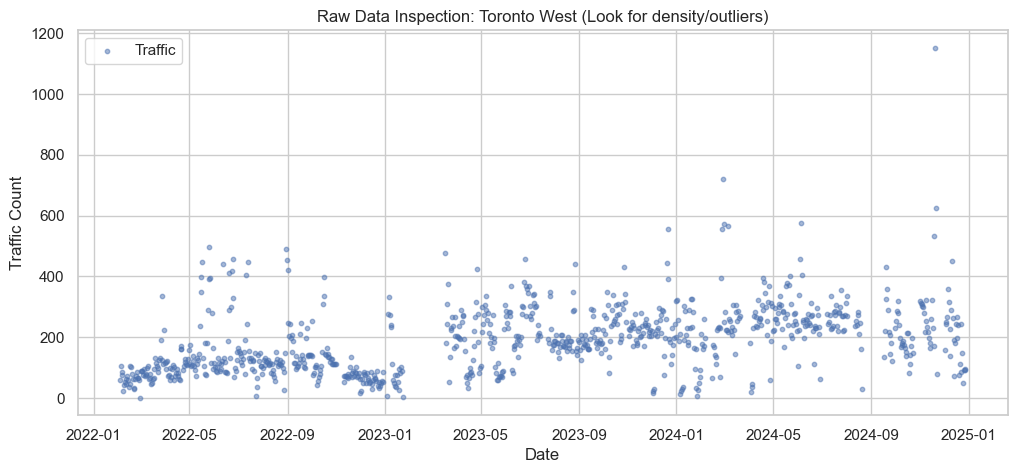

In [35]:
# --- DATA QUALITY CHECK: TORONTO WEST ---
station = "Toronto West"
print(f"🕵️‍♂️ STARTING AUDIT FOR: {station}")

# 1. Isolate Raw Data
df_audit = df_final[df_final['Station'] == station].copy()
df_audit['Date'] = pd.to_datetime(df_audit['Date'])

# --- CHECK 1: DUPLICATES ---
# The previous error said "cannot reindex on duplicate labels". Let's find them.
duplicates = df_audit[df_audit.duplicated(subset=['Date'], keep=False)]

print(f"\n1. DUPLICATES FOUND: {len(duplicates)} rows")
if not duplicates.empty:
    print("   Sample of conflicting days:")
    # Sort to see the pairs side-by-side
    print(duplicates.sort_values('Date')[['Date', 'traffic_count', 'NO2_Mean']].head(10))
else:
    print("   ✅ No duplicates found (Unique dates).")

# --- CHECK 2: MISSING DAYS (GAPS) ---
# Create a perfect daily range and see what's missing
min_date = df_audit['Date'].min()
max_date = df_audit['Date'].max()
full_range = pd.date_range(start=min_date, end=max_date, freq='D')

missing_dates = full_range.difference(df_audit['Date'])
print(f"\n2. TIME SERIES GAPS: {len(missing_dates)} missing days")
if len(missing_dates) > 0:
    print(f"   First 5 missing: {missing_dates[:5].date}")
    print(f"   Last 5 missing:  {missing_dates[-5:].date}")

# --- CHECK 3: PHYSICAL PLAUSIBILITY ( Zeros & Negatives) ---
print("\n3. DATA VALUES CHECK:")
print(f"   - Zero/Negative Traffic Days: {(df_audit['traffic_count'] <= 0).sum()}")
print(f"   - Zero/Negative NO2 Days:     {(df_audit['NO2_Mean'] <= 0).sum()}")
print(f"   - Missing Traffic Values:     {df_audit['traffic_count'].isna().sum()}")
print(f"   - Missing NO2 Values:         {df_audit['NO2_Mean'].isna().sum()}")

# --- VISUALIZATION ---
# Let's plot it to see if the "Duplicates" are just overlaps or real errors
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.scatter(df_audit['Date'], df_audit['traffic_count'], alpha=0.5, label='Traffic', s=10)
plt.title(f"Raw Data Inspection: {station} (Look for density/outliers)")
plt.xlabel("Date")
plt.ylabel("Traffic Count")
plt.legend()
plt.show()

In [ ]:
df_audit